In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
import glob


In [2]:
path_train_data = "./data/obj_detection/archive/train/"
path_test_data = "./data/obj_detection/archive/test/"
files_xml_annotation = glob.glob(path_train_data + "*.xml")


In [3]:
tree = ET.parse(files_xml_annotation[0])
root = tree.getroot()
member = root.findall("object")

member[0].find("bndbox").find("xmin").text


'97'

In [4]:
xml_list = []
for file in files_xml_annotation:
    tree = ET.parse(file)
    root = tree.getroot()
    for member in root.findall("object"):
        value = (
            root.find("filename").text,
            int(root.find("size").find("width").text),
            int(root.find("size").find("height").text),
            member.find("name").text,
            int(member.find("bndbox").find("xmin").text),
            int(member.find("bndbox").find("ymin").text),
            int(member.find("bndbox").find("xmax").text),
            int(member.find("bndbox").find("ymax").text),
        )
        xml_list.append(value)
columns = ["filename", "width", "height", "classes", "xmin", "ymin", "xmax", "ymax"]
xml_df = pd.DataFrame(xml_list, columns=columns)


In [5]:
xml_df.shape

(465, 8)

In [29]:
# setting box color and text color
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, text_color=TEXT_COLOR, thickness=2):
    xmin, ymin, xmax, ymax = [int(value) for value in bbox]
    cv.rectangle(img, (xmin, ymin), (xmax, ymax), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv.getTextSize(class_name, cv.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv.rectangle(img, (xmin, ymin - int(1.3 * text_height)), (xmin + text_width, ymin), color, -1)
    cv.putText(
        img,
        text=class_name,
        org=(xmin, ymin - int(0.3 * text_height)),
        fontFace=cv.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=text_color,
        lineType=cv.LINE_AA
    )
    return img


def visualize(img, bboxes, category_names):
    img = img.copy()
    for bbox, category_name in zip(bboxes, category_names):
        class_name = category_name
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)



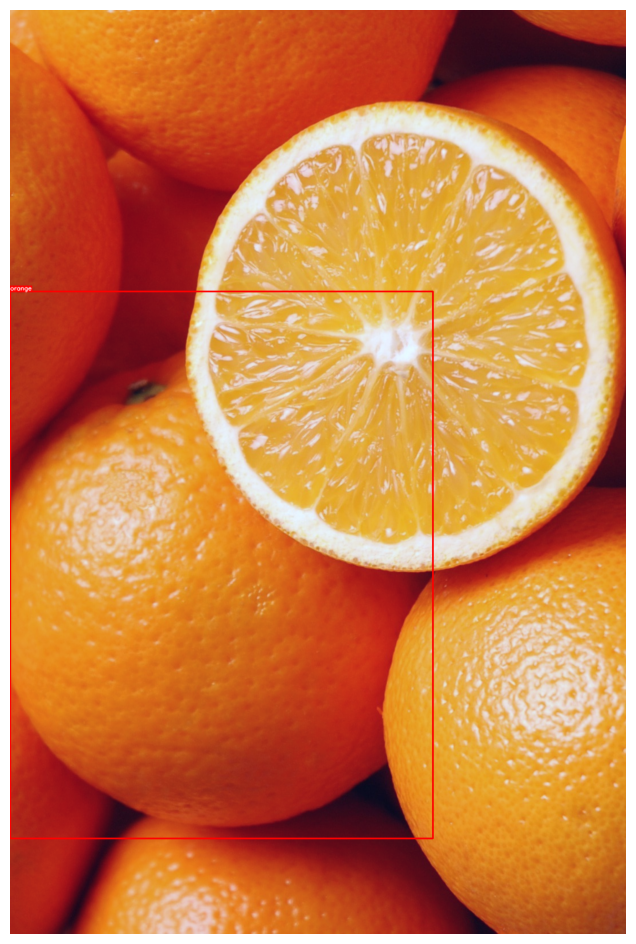

In [45]:
image = cv.imread(path_train_data + xml_df["filename"].to_list()[0])
# image = path_train_data

transformers = A.Compose([
    A.Flip(0.5),
    A.RandomRotate90(0.5),
    A.MotionBlur(p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.Blur(blur_limit=3, p=0.1),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    # ToTensorV2(p=1.0)
],
bbox_params={
    'format': 'pascal_voc',
    'label_fields': ['labels']
}
)

bboxes = []
labels = []
for i, row in xml_df.sample(1).iterrows():
    bbox = (row.xmin, row.ymin, row.xmax, row.ymax)
    path_image = path_train_data + row.filename
    image = cv.imread(path_image)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    class_name = row.classes
    labels.append(class_name)
    bboxes.append(bbox)
    transformation = transformers(image=image, bboxes=bboxes, labels=labels)
    visualize(transformation["image"], transformation["bboxes"], transformation["labels"])




In [28]:
transformation["image"]

array([[[234, 203, 177],
        [234, 203, 177],
        [234, 203, 177],
        ...,
        [246, 229, 214],
        [246, 229, 214],
        [246, 229, 214]],

       [[239, 211, 189],
        [239, 211, 189],
        [239, 211, 189],
        ...,
        [246, 229, 214],
        [246, 229, 214],
        [246, 229, 214]],

       [[241, 216, 195],
        [241, 216, 195],
        [241, 216, 195],
        ...,
        [246, 229, 214],
        [246, 229, 214],
        [246, 229, 214]],

       ...,

       [[246, 229, 214],
        [246, 227, 210],
        [246, 227, 210],
        ...,
        [234, 203, 177],
        [239, 207, 182],
        [239, 211, 189]],

       [[246, 227, 210],
        [246, 227, 210],
        [246, 227, 210],
        ...,
        [234, 203, 177],
        [231, 211, 188],
        [231, 211, 188]],

       [[247, 226, 208],
        [246, 227, 210],
        [246, 229, 214],
        ...,
        [231, 211, 188],
        [241, 216, 195],
        [241, 216, 195]]